<a href="https://colab.research.google.com/github/PeriniM/weights-generation-ROS/blob/main/Reduce_errors_weights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# **Weights and Errors Analysis**

Importing the errors and weights associated to each simulation

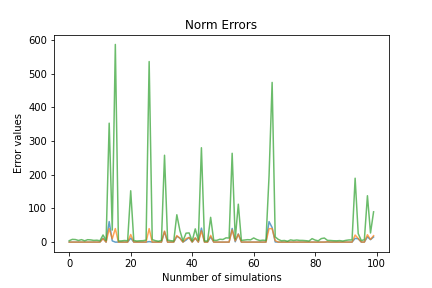

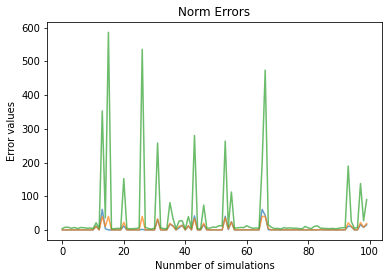

In [ ]:
errors = np.load('errors_1e3k.npy')
weights = np.load('weights_1e3k.npy')
plt.plot(errors[:100,0],alpha=0.7)
plt.plot(errors[:100,1],alpha=0.7)
plt.plot(errors[:100,2],alpha=0.7)
plt.ylabel('Error values')
plt.xlabel('Nunmber of simulations')
plt.title('Norm Errors')
plt.show()

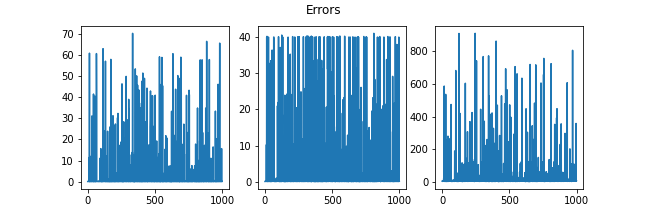

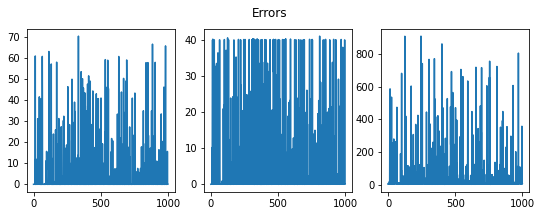

In [ ]:
plt.figure(figsize=(9, 3))
plt.subplot(131)
plt.plot(errors[:,0])
plt.subplot(132)
plt.plot(errors[:,1])
plt.subplot(133)
plt.plot(errors[:,2])
plt.suptitle('Errors')
plt.show()

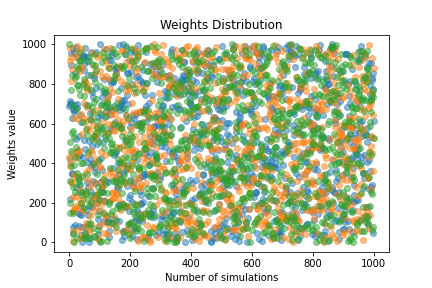

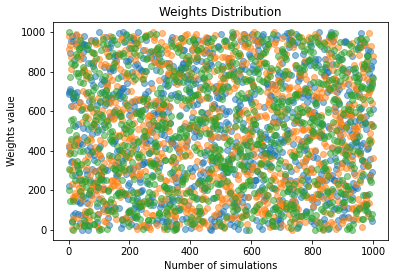

In [ ]:
plt.scatter(range(weights.shape[0]),weights[:,0],alpha=0.5)
plt.scatter(range(weights.shape[0]),weights[:,1],alpha=0.5)
plt.scatter(range(weights.shape[0]),weights[:,2],alpha=0.5)
plt.title('Weights Distribution')
plt.ylabel('Weights value')
plt.xlabel('Number of simulations')
plt.show()

Show the weights in 3D

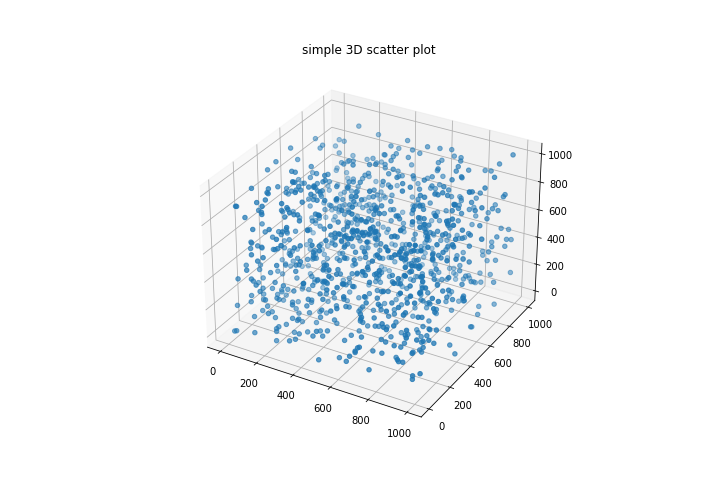

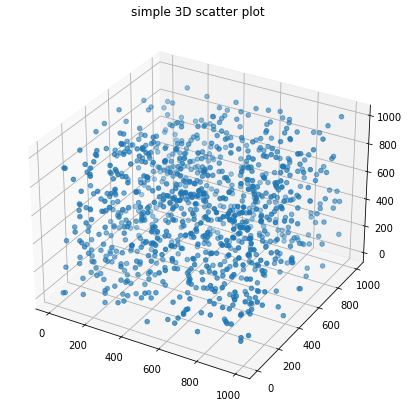

In [ ]:
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(weights[:,0],weights[:,1],weights[:,2])
plt.title("simple 3D scatter plot")
 
# show plot
plt.show()

Find the weights that got the norm of errors smaller than 3.0

In [ ]:
first = 1
norm = 1000000
for i in range(errors.shape[0]):
  err = np.linalg.norm(errors[i,:], 2)
  if err < 3.0:
    if first:
      weights_new = np.array([weights[i,:]])
      errors_new = np.array([errors[i,:]])
      first = 0
    else:
      weights_new = np.append(weights_new, [weights[i,:]],axis=0)
      errors_new = np.append(errors_new, [errors[i,:]],axis=0)
  if err<norm:
    norm = err
    a = i

2.2068916583564544


Print the weights combination that got the smallest error

In [ ]:
print(weights[a,:])
print(errors[a,:])

[164  71 930]
[0.05888487 0.03219983 2.20587092]


Visualize in 3D the weights that got the smallest errors

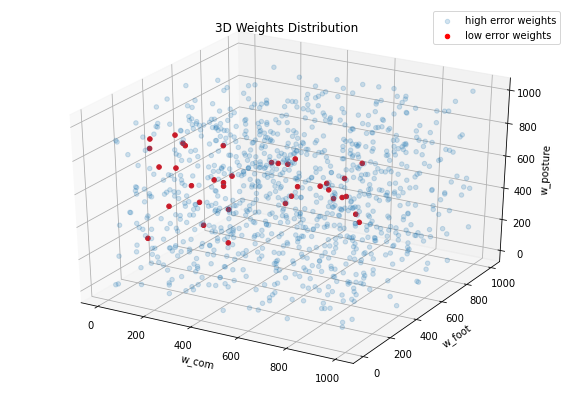

In [ ]:
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(weights[:,0],weights[:,1],weights[:,2],zorder=1,alpha=0.2)
ax.scatter3D(weights_new[:,0],weights_new[:,1],weights_new[:,2], color='r',zorder=2,alpha=1)
plt.legend(['high error weights','low error weights'])
plt.title("3D Weights Distribution")
plt.xlabel("w_com")
plt.ylabel("w_foot")
ax.set_zlabel("w_posture")
# show plot
plt.show()

Visualize in 2D the weights that got the smallest errors

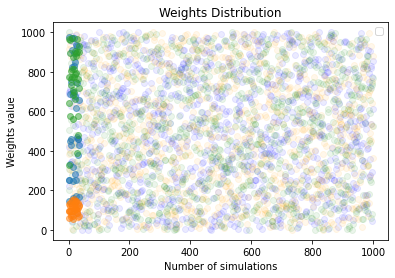

In [ ]:
plt.legend(['high error weights','low error weights'])
plt.title("3D Weights Distribution")
colors = ['b','orange','g']
for i in range(weights.shape[1]):
  plt.scatter(range(weights.shape[0]),weights[:,i],zorder=1,alpha=0.08,color = colors[i])
  plt.scatter(range(weights_new.shape[0]),weights_new[:,i],zorder=2,alpha=0.5)
plt.title('Weights Distribution')
plt.ylabel('Weights value')
plt.xlabel('Number of simulations')
# show plot
plt.show()

# **MLP Model**

In [ ]:
%pip install livelossplot

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden1 (Dense)             (None, 10)                40        
                                                                 
 hidden2 (Dense)             (None, 10)                110       
                                                                 
 Output (Dense)              (None, 3)                 33        
                                                                 
Total params: 183
Trainable params: 183
Non-trainable params: 0
_________________________________________________________________


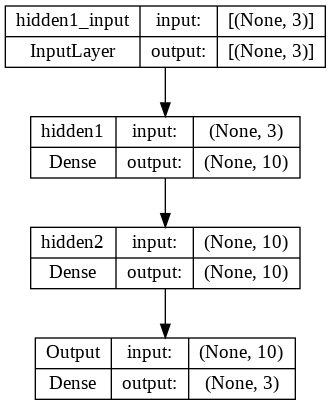

In [ ]:
# use mlp for prediction on multi-output regression
from numpy import asarray
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
from livelossplot import PlotLossesKeras

model_input = errors
model_output = weights
# get the model
def get_model(in_dim, out_dim):
  model = Sequential()
  model.add(Dense(10, input_dim=in_dim, kernel_initializer='he_uniform', activation='selu',name="hidden1"))
  #model.add(Dropout(0.2))
  model.add(Dense(10, kernel_initializer='he_uniform', activation='selu',name="hidden2"))
  model.add(Dense(out_dim, kernel_initializer='he_uniform',name="Output"))
  model.compile(loss='mae', optimizer='adam')
  model.summary()
  return model
x, y = (model_input, model_output)
xtrain, xtest, ytrain, ytest=train_test_split(x, y, test_size=0.15)
n_inputs, n_outputs = xtrain.shape[1], ytrain.shape[1]
# get model
model = get_model(n_inputs, n_outputs)
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

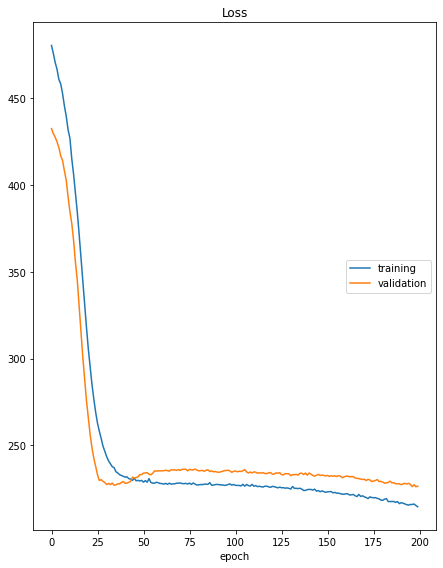

Loss
	training         	 (min:  214.501, max:  480.594, cur:  214.501)
	validation       	 (min:  226.040, max:  432.613, cur:  226.396)


1/1 [==============================] - 0s 168ms/step
Predicted: [520.4056  492.45813 490.91284]


In [ ]:
# fit the model on all data
model.fit(xtrain, ytrain,
          epochs=200,
          validation_data=(xtest, ytest),
          callbacks=[PlotLossesKeras()],
          verbose=0,
          batch_size=3)

In [ ]:
# make a prediction for new data
x2pred = asarray([xtest[0,:]])
ypred = model.predict(x2pred)
print('Predicted: %s' % ypred[0])

In [ ]:
zero_err = asarray([np.array([0.00000000,0.00000000,0.00000000])])
ypred = model.predict(zero_err)
print('Predicted: %s' % ypred[0])

1/1 [==============================] - 0s 31ms/step
Predicted: [206.93817 102.12042 245.72617]
